In [ ]:
# Purpose of the code:
    # Create a classification model to predict the level of MSFC scores
        # Model: Random Forest
        # Validation: 10-fold cross validation

In [209]:
# necessay imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [210]:
# switch to a proper directory to access the data
cd /camdatalake/bronze/verily_ms/device/

/camdatalake/bronze/verily_ms/device


In [211]:
# download and read the data

# FeatureDay: Average value of the features for each day of study. Days are listed as 
# DayOfStudy

# FeatureStudy: Features for the entire study period.For the at home features, 
# the reported value is the median of the observed day level values.

import gzip, csv
with gzip.open("FeaturesDay.csv.gz", "rt", newline="") as file:
    FeatureDay = pd.read_csv(file, header = 0)

with gzip.open("FeaturesStudy.csv.gz", "rt", newline="") as file:
    FeatureStudy = pd.read_csv(file, header = 0)

In [212]:
# explore the datasets
FeatureDay.shape

(1532, 217)

In [213]:
FeatureStudy.shape

(25, 216)

In [214]:
def filter_dataFrame(df):
    # a function to extract the sensor related measurements from the original dataset (df)
    Selected_features = []
    df_columns_names = list(df.columns)
    # patient ID(1 column)
    Selected_features.append('gls_subject_code')
    # related to msfc_composite(3 columns)
    df_columns_MSFC_col_names = []
    for name in df_columns_names:
        name_lowercase = name.lower()
        if 'msfc_composite' in name_lowercase:
            df_columns_MSFC_col_names.append(name)
    # structred activities at home(40 columns)
    df_at_home_col_names = []
    for name in df_columns_names:
        name_lower = name.lower()
        if 'home' in name_lower:
            df_at_home_col_names.append(name)
    # free-living features(20 columns)
    # extracted before in Data_Visualization_Part_1_FeatureStudy_Correlation_of_Sensor_Features_to_MSFC.py, and saved
    df_free_living_related = pd.read_csv('FeatureStudy_free_living_related')
    df_free_living_col_names = list(df_free_living_related.columns)
    # add everything to Selected_features list
    Selected_features += list(df_free_living_related.columns)
    Selected_features += df_at_home_col_names
    Selected_features += df_columns_MSFC_col_names
    # return filtered dataframe with selected features
    return df[Selected_features]

In [215]:
def filter_dataFrame_fillna(df):
    # a function to fill null values in the input dataframe (df)
    df_columns_names = list(df.columns)
    # patient ID(1 column)
    df_columns_patientID_col_names =['gls_subject_code']
    df_patientID= df[df_columns_patientID_col_names]
    # related to msfc_composite(3 columns)
    df_columns_MSFC_col_names = []
    for name in df_columns_names:
        name_lowercase = name.lower()
        if 'msfc_composite' in name_lowercase:
            df_columns_MSFC_col_names.append(name)
    df_msfcComposite = df[df_columns_MSFC_col_names]
    # structred activities at home(40 columns)
    df_at_home_col_names = []
    for name in df_columns_names:
        name_lower = name.lower()
        if 'home' in name_lower:
            df_at_home_col_names.append(name)
    df_structuredActivity_atHome = df[df_at_home_col_names]
    # free living features(20 columns)
    df_all_except_freeLiving_col_names = df_columns_patientID_col_names + df_columns_MSFC_col_names + df_at_home_col_names
    df_free_living_col_names = list(set(df_columns_names) - set(df_all_except_freeLiving_col_names))
    df_freeLiving = df[df_free_living_col_names]
    
    # fill null values by row for df_msfcComposite
    for idx in range(len(df_msfcComposite.index)):
        df_msfcComposite.iloc[idx].fillna(df_msfcComposite.iloc[idx].mean(), inplace = True)
    # fill null values by column for df_structuredActivity_atHome
    for col_name in list(df_structuredActivity_atHome.columns):
        df_structuredActivity_atHome[col_name].fillna(df_structuredActivity_atHome[col_name].mean(),inplace= True)
    # fill null values by column for df_freeLiving
    for col_name in list(df_freeLiving.columns):
        df_freeLiving[col_name].fillna(df_freeLiving[col_name].mean(),inplace= True)
    
    # return the updated dataframe with filled null values
    return pd.concat([df_patientID,df_freeLiving,df_structuredActivity_atHome,df_msfcComposite],axis=1)

In [216]:
def remove_rows_with_null(df,TH):
    # a function to remove rows from df with more than TH% of value points missing
    indexes = []
    count_null = df.isnull().sum(axis=1)
    for idx in range(len(count_null)):
        if count_null[idx] > TH:
            indexes.append(idx)
    df_filtered = df.drop(indexes)
    # return the new dataframe
    return df_filtered.reset_index(drop=True)

In [217]:
def remove_columns_with_null(df,TH):
    # a function to remove columns from df with more than TH% of value points missing
    indexes = []
    count_null = df.isnull().sum()
    col_labels = list(count_null.index)
    for idx in range(len(count_null)):
        if count_null[idx] > TH:
            indexes.append(col_labels[idx])
    df_filtered = df.drop(indexes, axis=1)
    # return the new dataframe
    return df_filtered.reset_index(drop=True)

In [218]:
def bin_scores(val,num_of_bins, minimum, maximum):
    # a function to bin the scores
    # input: 
        # val: input value to bin
        # num_of_bins: desired number of bins
        # minimum & maximum: specify the range of values
    # output:
        # binned value
    step = (maximum - minimum)/num_of_bins
    curr_val = minimum
    level = 1
    while(curr_val < maximum):
        curr_val += step
        if val <= curr_val:
            return level
        else:
            level += 1

In [219]:
# extract part of the original dataset which is related to sensor measurements
FeatureStudy_filtered = filter_dataFrame(FeatureStudy)
FeatureDay_filtered = filter_dataFrame(FeatureDay)

In [220]:
#######################################################RESHAPE FEATURESDAY#########################################

In [ ]:
# to consider the time component, we take pair of (feature_value, day_of_study) as a new feature

In [221]:
# check the original dataset
FeatureDay_filtered.head()

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,-1.211435,-1.385647,-1.40763
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,-1.211435,-1.385647,-1.40763
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,-1.211435,-1.385647,-1.40763
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,-1.211435,-1.385647,-1.40763
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,-1.211435,-1.385647,-1.40763


In [222]:
# drop composite scores, we do not have any varoius values for them over days
FeatureDay_filtered_device_features = FeatureDay_filtered.drop(['msfc_composite_1','msfc_composite_2','msfc_composite_3'],axis=1)
FeatureDay_filtered_device_features.head()
FeatureDay_filtered_device_features.shape

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_lr_at_home,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,424.878675,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,460.529853,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,371.773641,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,408.234556,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,380.493350,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555


(1532, 61)

In [223]:
# will need days of study as an index, add to the dataset
FeatureDay_filtered_device_features['dayofstudy'] = FeatureDay['dayofstudy']
FeatureDay_filtered_device_features.head()
FeatureDay_filtered_device_features.shape

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,dayofstudy
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,23
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,34
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,4
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,11
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,15


(1532, 62)

In [224]:
# extract patient IDs
patientIDs = FeatureDay_filtered['gls_subject_code'].unique()
patientIDs

array(['H800001', 'H800002', 'H800003', 'H800004', 'H800006', 'H800007',
       'H800008', 'H800009', 'H800010', 'H800011', 'H800013', 'H800014',
       'H800016', 'H800017', 'H800018', 'H800019', 'H800020', 'H800021',
       'H800022', 'H800023', 'H800024', 'H800025', 'H800005', 'H800012',
       'H800015'], dtype=object)

In [225]:
# what is the maximum number of study days for patients?
num_of_days_of_study = [FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].shape[0] for ID in patientIDs]
days_of_study = pd.DataFrame()
days_of_study['patientID'] = patientIDs
days_of_study['num_of_days'] = num_of_days_of_study
days_of_study.head()
max_num_of_days = max(days_of_study['num_of_days'])

,patientID,num_of_days
0,H800001,62
1,H800002,63
2,H800003,68
3,H800004,65
4,H800006,79


In [226]:
# device features dataset + patient IDs + day of study + composite scores
FeatureDay_filtered_device_features.head()

,gls_subject_code,turn_vel_std,turn_vel_mean_ankle,movement_rate,turn_vel_mean,turn_vel_std_ankle,turn_duration,turn_angle,walk_minutes,swing,...,sway_disp_ap_at_home,mobility_activity_at_home_time,hrv_sdnn_at_home,hourly_temp_median_at_home,hourly_temp_std_at_home,hourly_temp_range_at_home,hourly_amb_temp_median_at_home,hourly_amb_temp_std_at_home,hourly_amb_temp_range_at_home,dayofstudy
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,288.195255,66170.0,NaN,32.70,0.760989,1.905,30.7575,4.330252,11.7550,23
1,H800001,19.335984,40.692564,5.241188,56.845986,62.676670,0.38,21.143974,245.125000,0.392413,...,251.594150,NaN,14.108786,32.85,0.532629,1.350,29.5875,6.815948,15.8120,34
2,H800001,17.776043,47.155710,NaN,61.391091,60.985627,0.44,25.782601,182.166667,0.424840,...,301.790876,27070.0,15.028955,31.60,0.717705,1.800,30.2200,3.545528,7.3300,4
3,H800001,15.764536,46.102694,NaN,61.178408,59.345718,0.38,23.391290,99.208333,0.424863,...,262.974920,30230.0,NaN,30.75,1.689474,5.550,27.3600,4.984148,13.5820,11
4,H800001,15.250615,43.762170,NaN,61.247844,57.424167,0.40,24.056450,136.333333,0.441570,...,282.825979,29875.0,NaN,30.65,0.830880,2.205,30.6825,4.699070,13.8555,15


In [227]:
# just keep the sensor feature values
device_feature_names = list(FeatureDay_filtered_device_features.drop(['gls_subject_code','dayofstudy'],axis = 1))
len(device_feature_names)

60

In [228]:
# transform the dataset, add feature values for each day as a new column
final_df = pd.DataFrame()
for ID in patientIDs:
    print(ID)
    arr = ID.split('0')
    sub_df = FeatureDay_filtered_device_features[FeatureDay_filtered_device_features['gls_subject_code'] == ID]
    new_df = pd.DataFrame()
    new_df['gls_subject_code'] = [ID]
    for day in np.arange(1,max_num_of_days + 1):
        for feature in device_feature_names:
            col_name = feature + '_day_' + str(day)
            if day in sub_df['dayofstudy'].tolist():
                idx = sub_df['dayofstudy'].tolist().index(23)
                val = sub_df.iloc[idx][feature]
                new_df[col_name] = [val]
            else:
                new_df[col_name] = [np.nan]
    final_df = pd.concat([final_df,new_df])

H800001
H800002
H800003
H800004
H800006
H800007
H800008
H800009
H800010
H800011
H800013
H800014
H800016
H800017
H800018
H800019
H800020
H800021
H800022
H800023
H800024
H800025
H800005
H800012
H800015


In [229]:
# check the transformed dataframe
final_df.head()
final_df.shape

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,sway_disp_lr_at_home_day_80,sway_disp_ap_at_home_day_80,mobility_activity_at_home_time_day_80,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(25, 4801)

In [230]:
# add back patient IDs + composite scores to the transformed dataset
msfc_composite_1 = []
msfc_composite_2 = []
msfc_composite_3 = []
for ID in final_df['gls_subject_code']:
    msfc_composite_1.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_1'])
    msfc_composite_2.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_2'])
    msfc_composite_3.append(FeatureDay_filtered[FeatureDay_filtered['gls_subject_code'] == ID].iloc[0]['msfc_composite_3'])
final_df['msfc_composite_1'] = msfc_composite_1
final_df['msfc_composite_2'] = msfc_composite_2
final_df['msfc_composite_3'] = msfc_composite_3
final_df.head()

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.211435,-1.385647,-1.407630
0,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389599,1.109154,0.631568
0,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780895,0.932657,0.911542
0,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.969236,-0.983236,-0.695738
0,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245690,0.568276,0.495086


In [231]:
# fix the index of the transformed dataset
FeatureDay_filtered_reshaped = final_df.reset_index(drop=True)
FeatureDay_filtered_reshaped.head()

,gls_subject_code,turn_vel_std_day_1,turn_vel_mean_ankle_day_1,movement_rate_day_1,turn_vel_mean_day_1,turn_vel_std_ankle_day_1,turn_duration_day_1,turn_angle_day_1,walk_minutes_day_1,swing_day_1,...,hrv_sdnn_at_home_day_80,hourly_temp_median_at_home_day_80,hourly_temp_std_at_home_day_80,hourly_temp_range_at_home_day_80,hourly_amb_temp_median_at_home_day_80,hourly_amb_temp_std_at_home_day_80,hourly_amb_temp_range_at_home_day_80,msfc_composite_1,msfc_composite_2,msfc_composite_3
0,H800001,22.174349,48.212574,6.701800,57.883232,60.263901,0.42,23.911008,149.375000,0.427722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.211435,-1.385647,-1.407630
1,H800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389599,1.109154,0.631568
2,H800003,14.908525,35.120240,4.488399,66.330916,92.738296,0.50,29.897820,64.500000,0.420198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780895,0.932657,0.911542
3,H800004,17.141517,55.996969,10.324276,66.854706,65.144946,0.44,28.332181,61.458333,0.495820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.969236,-0.983236,-0.695738
4,H800006,24.291345,52.741362,3.316912,64.354366,81.240676,0.72,43.488300,178.375000,0.465371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245690,0.568276,0.495086


In [232]:
###################################################END OF REASHAPING FEATUREDAY####################################

In [233]:
# preprocessing: remove columns, rows with > 50% null values

# featureStudy
# columns
TH = FeatureStudy_filtered.shape[0]/2
FeatureStudy_filtered_nullDropped = remove_columns_with_null(FeatureStudy_filtered, TH)
# rows
TH = FeatureStudy_filtered.shape[1]/2
FeatureStudy_filtered_nullDropped = remove_rows_with_null(FeatureStudy_filtered_nullDropped, TH)

# featureDay
# columns
TH = FeatureDay_filtered_reshaped.shape[0]/2
FeatureDay_filtered_reshaped_nullDropped = remove_columns_with_null(FeatureDay_filtered_reshaped, TH)
# rows
TH = FeatureDay_filtered_reshaped_nullDropped.shape[1]/2
FeatureDay_filtered_reshaped_nullDropped = remove_rows_with_null(FeatureDay_filtered_reshaped_nullDropped, TH)

# compare shapes of new data frames with original ones
FeatureStudy_filtered.shape
FeatureStudy_filtered_nullDropped.shape
FeatureDay_filtered_reshaped.shape
FeatureDay_filtered_reshaped_nullDropped.shape

(25, 64)

(22, 64)

(25, 4804)

(20, 1830)

In [234]:
# preprocessing: fill null values
# MSFC composite scores: mean on row
# feature values: mean on columns
df_study = filter_dataFrame_fillna(FeatureStudy_filtered_nullDropped)
df_day = filter_dataFrame_fillna(FeatureDay_filtered_reshaped_nullDropped)

/opt/python3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [235]:
# check to make sure there is no null value left
df_day.shape
df_day.isnull().sum().sum()
df_study.shape
df_study.isnull().sum().sum()

(20, 1830)

0

(22, 64)

0

In [236]:
# removed patients
set(patientIDs) - set(df_day['gls_subject_code'])
set(patientIDs) - set(df_study['gls_subject_code'])

{'H800002', 'H800005', 'H800009', 'H800012', 'H800015'}

{'H800005', 'H800012', 'H800015'}

In [237]:
# data engineering: add MSFC3-MSFC2 to the datasets
# there are three potential targets to predict: msfc_composite_3, msfc_change, msfc_composite_3_bin
df_study['msfc_change'] = df_study['msfc_composite_3'] - df_study['msfc_composite_2']
df_day['msfc_change'] = df_day['msfc_composite_3'] - df_day['msfc_composite_2']

In [238]:
# data engineering: add binned msfc3 scores to the dataset
num_of_bins = 3
minimum =  df_study['msfc_composite_3'].min()
maximum = df_study['msfc_composite_3'].max()
df_study['msfc_composite_3_bin'] = df_study['msfc_composite_3'].apply(bin_scores, args=(num_of_bins, minimum, maximum))

num_of_bins = 3
minimum =  df_day['msfc_composite_3'].min()
maximum = df_day['msfc_composite_3'].max()
df_day['msfc_composite_3_bin'] = df_day['msfc_composite_3'].apply(bin_scores, args=(num_of_bins, minimum, maximum))

In [ ]:
# start the classification while msfc scores from previous clinical visits are considered as features in datasets

In [321]:
# prepare x,y
# df_study
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_study = df_study.drop(col_names_potential_targets,axis=1)
y_study = df_study['msfc_composite_3_bin']

# normalize data
from sklearn import preprocessing
x_study_scaled = pd.DataFrame(preprocessing.normalize(x_study),columns=x_study.columns)

In [322]:
# prepare x,y
# df_day
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_day = df_day.drop(col_names_potential_targets,axis=1)
y_day = df_day['msfc_composite_3_bin']

# normalize data
from sklearn import preprocessing
x_day_scaled = pd.DataFrame(preprocessing.normalize(x_day),columns=x_day.columns)

In [323]:
# summerize the results in a dataframe
summary_1 = pd.DataFrame()
best_accuracy_score = []
accuracy_of_best_model_on_whole_data = []
best_num_of_estimator = []
train_data = []
target = []
num_of_samples = []
num_of_features = []

In [324]:
# random forest
# train data: df_study
# target: binned_msfc3
# validation: 10_fold cross validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
# train and fit the model
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': np.arange(5,100,5)}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=10)
grid_clf.fit(x_study, y_study)
# get the parameters
grid_clf.best_score_
grid_clf.best_params_
grid_clf.grid_scores_
# get the confusion matrix and accuracy_score
rf = grid_clf.best_estimator_
preds = rf.predict(x_study)
confusion_matrix(preds, y_study)
accuracy_score(preds, y_study)
# get the 20 first important features
l = rf.feature_importances_
df = pd.DataFrame()
df['feature'] = list(x_study.columns)
df['importance'] = l
df.sort('importance', ascending = False).head(20)
# store the result
best_accuracy_score.append(grid_clf.best_score_)
best_num_of_estimator.append(grid_clf.best_params_['n_estimators'])
train_data.append('FeatureStudy')
target.append('msfc3_level')
num_of_samples.append(len(y_study))
num_of_features.append(x_study.shape[1])
accuracy_of_best_model_on_whole_data.append(accuracy_score(preds, y_study))

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

0.86363636363636365

{'n_estimators': 20}

[mean: 0.81818, std: 0.17500, params: {'n_estimators': 5},
 mean: 0.81818, std: 0.17500, params: {'n_estimators': 10},
 mean: 0.81818, std: 0.17500, params: {'n_estimators': 15},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 20},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 25},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 30},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 35},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 40},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 45},
 mean: 0.81818, std: 0.14530, params: {'n_estimators': 50},
 mean: 0.81818, std: 0.14530, params: {'n_estimators': 55},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 60},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 65},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 70},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 75},
 mean: 0.86364, std: 0.12910, params: {'n_estimators': 80},
 mean: 0.86364, std: 0.12910, params: {'n

array([[ 2,  0,  0],
       [ 0,  4,  0],
       [ 0,  0, 16]])

1.0

/opt/python3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
61,msfc_composite_2,0.120729
21,mean_pvt_delay_3_at_home,0.120552
24,mean_pvt_delay_at_home,0.079606
23,mean_pvt_delay_7_at_home,0.069225
20,mean_pvt_delay_1_at_home,0.053505
4,prv_sdnn,0.050000
7,turn_vel_mean_ankle,0.044880
30,zx_nondominant_num_correct_at_home,0.037280
37,mobility_swing_at_home,0.037046
26,pq_nondominant_median_at_home,0.032451


In [325]:
# random forest
# train data: df_day
# target: binned_msfc3
# validation: 10-fold cross validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
# train and fit the model
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': np.arange(5,100,5)}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=10)
grid_clf.fit(x_day, y_day)
# get the parameters
grid_clf.best_score_
grid_clf.best_params_
grid_clf.grid_scores_
# get the confusion matrix and accuracy_score
rf = grid_clf.best_estimator_
preds = rf.predict(x_day)
confusion_matrix(preds, y_day)
accuracy_score(preds, y_day)
# get the 20 first important features
l = rf.feature_importances_
df = pd.DataFrame()
df['feature'] = list(x_day.columns)
df['importance'] = l
df.sort('importance', ascending = False).head(20)
# store the result
best_accuracy_score.append(grid_clf.best_score_)
best_num_of_estimator.append(grid_clf.best_params_['n_estimators'])
train_data.append('FeatureDay')
target.append('msfc3_level')
num_of_samples.append(len(y_day))
num_of_features.append(x_day.shape[1])
accuracy_of_best_model_on_whole_data.append(accuracy_score(preds, y_day))

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

0.75

{'n_estimators': 10}

[mean: 0.70000, std: 0.25941, params: {'n_estimators': 5},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 10},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 15},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 20},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 25},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 30},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 35},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 40},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 45},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 50},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 55},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 60},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 65},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 70},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 75},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 80},
 mean: 0.75000, std: 0.20817, params: {'n

array([[ 1,  0,  0],
       [ 0,  3,  0],
       [ 1,  0, 15]])

0.94999999999999996

/opt/python3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
920,turn_vel_std_day_44,0.100000
1103,mean_pvt_delay_7_at_home_day_4,0.100000
679,turn_vel_max_ankle_day_58,0.079747
657,idle_minutes_day_28,0.076266
675,turn_duration_ankle_day_31,0.072973
645,turn_angle_ankle_day_1,0.071905
646,stance_day_61,0.064286
343,turn_vel_mean_ankle_day_8,0.059270
1756,hourly_temp_range_at_home_day_58,0.056427
1367,mean_pvt_delay_7_at_home_day_26,0.043905


In [326]:
# fill summary dataframe
summary_1['train_data'] = train_data
summary_1['target'] = target
summary_1['num_of_samples'] = num_of_samples
summary_1['num_of_features'] = num_of_features
summary_1['best_num_of_estimator'] = best_num_of_estimator
summary_1['mean_accuracy_score'] = best_accuracy_score
summary_1['accuracy_on_whole_data'] = accuracy_of_best_model_on_whole_data
summary_1

,train_data,target,num_of_samples,num_of_features,best_num_of_estimator,mean_accuracy_score,accuracy_on_whole_data
0,FeatureStudy,msfc3_level,22,62,20,0.863636,1.00
1,FeatureDay,msfc3_level,20,1828,10,0.750000,0.95


In [327]:
# PCA transformation

In [328]:
# normalize the data
# normalizing each feaure values in datasets based on the columns
x_study_normalized = (x_study - x_study.mean()) / (x_study.max() - x_study.min())
x_day_normalized = (x_day - x_day.mean()) / (x_day.max() - x_day.min())

In [329]:
# summerize the results in a dataframe
summary_2 = pd.DataFrame()
best_accuracy_score = []
num_of_estimators = []
train_data = []
target = []
num_of_samples = []
best_num_of_PCAs = []
accuracy_of_best_model_on_whole_data = []

In [330]:
# random forest
# train data: df_study, pca transformation
# target: binned_msfc3
# validation: 10_fold cross validation
# see how the number of PCs can change the accuracy of transformation

n_estimators = 20
k = 10
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
accuracy = []
# use various number of PCs
for pc_num in np.arange(1,20,1):
    # PCA transformation
    pca = PCA(n_components=pc_num)
    pca.fit(x_study_normalized)
    x_study_pca = pca.transform(x_study_normalized)
    # put the transformed data to a dataframe
    df_study_pca = pd.DataFrame(x_study_pca)
    # fit the model and do cross validation using PCA transformed dataset
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state = 42) #fix the number of estimators the best 
    accuracy.append(np.mean(cross_val_score(clf, df_study_pca, y_study, cv=k))) 
# max accuracy? what number of PCAs?
max_acc = accuracy[np.argmax(accuracy)]
best_num_of_PCA = np.arange(1,20,1)[np.argmax(accuracy)]
# print out the results
print(max_acc)
print(best_num_of_PCA)
# store the result
best_accuracy_score.append(max_acc)
best_num_of_PCAs.append(best_num_of_PCA)
train_data.append('FeatureStudy_PCA_transformed')
target.append('msfc3_level')
num_of_samples.append(len(y_study))
num_of_estimators.append(n_estimators)

PCA(copy=True, n_components=1, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=2, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=3, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=4, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=5, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=6, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=7, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=8, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=9, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=10, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=11, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=12, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=13, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=14, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=15, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=16, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=17, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=18, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=19, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


0.883333333333
2


In [331]:
# random forest
# train data: df_study, pca transformation
# target: binned_msfc3
# validation: 10-fold cross validation
# what is the best model accuracy on the whole dataset?

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
pc_num = 2
estimator_num = 20
k = 10
# PCA transformation
pca = PCA(n_components=pc_num)
pca.fit(x_study_normalized)
x_study_pca = pca.transform(x_study_normalized)
# variance explained by each PCA
explained_var = list(pca.explained_variance_)
PCA_list = np.arange(1, pc_num + 1)
df_explained_var = pd.DataFrame(explained_var,index=PCA_list,columns=['Explained Variance'])
df_explained_var
# put the transformed data to a dataframe
df_study_pca = pd.DataFrame(x_study_pca)
# fit the model and do cross validation using PCA transformed dataset
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': [estimator_num]}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=k)
grid_clf.fit(df_study_pca, y_study)
# try the model on the whole dataset
preds = grid_clf.best_estimator_.predict(df_study_pca)
accuracy_score(y_study, preds)
confusion_matrix(y_study, preds)
# store the result
accuracy_of_best_model_on_whole_data.append(accuracy_score(y_study, preds))

PCA(copy=True, n_components=2, whiten=False)

,Explained Variance
1,0.870880
2,0.466023


/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

1.0

array([[ 2,  0,  0],
       [ 0,  4,  0],
       [ 0,  0, 16]])

In [332]:
# random forest
# train data: df_day, pca transformation
# target: msfc3 level
# validation: 10-fold cross validation
# see how the number of PCs can change the accuracy of transformation

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
accuracy = []
n_estimators = 10
k = 10
# use various number of PCs
for pc_num in np.arange(1,20,1):
    # PCA transformation
    pca = PCA(n_components=pc_num)
    pca.fit(x_day_normalized)
    x_day_pca = pca.transform(x_day_normalized)
    # put the transformed data to a dataframe
    df_day_pca = pd.DataFrame(x_day_pca)
    # fit the model and do cross validation using PCA transformed dataset
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state = 42) #fix the number of estimators the best 
    accuracy.append(np.mean(cross_val_score(clf, df_day_pca, y_day, cv=k))) 
# max accuracy? what number of PCAs?
max_acc = accuracy[np.argmax(accuracy)]
best_num_of_PCA = np.arange(1,20,1)[np.argmax(accuracy)]
# print out the results
print(max_acc)
print(best_num_of_PCA)
# store the result
best_accuracy_score.append(max_acc)
best_num_of_PCAs.append(best_num_of_PCA)
train_data.append('FeatureDay_PCA_transformed')
target.append('msfc3_level')
num_of_samples.append(len(y_day))
num_of_estimators.append(n_estimators)

PCA(copy=True, n_components=1, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=2, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=3, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=4, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=5, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=6, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=7, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=8, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=9, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=10, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=11, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=12, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=13, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=14, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=15, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=16, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=17, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=18, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=19, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


0.866666666667
7


In [333]:
# random forest
# train data: df_day, pca transformation
# target: binned_msfc3
# validation: 10-fold cross validation
# what is the best model accuracy on the whole dataset?

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
pc_num = 7
estimator_num = 10
k = 10
# PCA transformation
pca = PCA(n_components=pc_num)
pca.fit(x_day_normalized)
x_day_pca = pca.transform(x_day_normalized)
# variance explained by each PCA
explained_var = list(pca.explained_variance_)
PCA_list = np.arange(1, pc_num + 1)
df_explained_var = pd.DataFrame(explained_var,index=PCA_list,columns=['Explained Variance'])
df_explained_var
# put the transformed data to a dataframe
df_day_pca = pd.DataFrame(x_day_pca)
# fit the model and do cross validation using PCA transformed dataset
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': [estimator_num]}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=k)
grid_clf.fit(df_day_pca, y_day)
# try the model on the whole dataset
preds = grid_clf.best_estimator_.predict(df_day_pca)
accuracy_score(y_day, preds)
confusion_matrix(y_day, preds)
# store the result
accuracy_of_best_model_on_whole_data.append(accuracy_score(y_day, preds))

PCA(copy=True, n_components=7, whiten=False)

,Explained Variance
1,26.488498
2,20.826458
3,13.252714
4,10.647363
5,8.217323
6,7.081441
7,6.164811


/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

0.94999999999999996

array([[ 1,  0,  1],
       [ 0,  3,  0],
       [ 0,  0, 15]])

In [334]:
# fill summary dataframe
summary_2['train_data'] = train_data
summary_2['target'] = target
summary_2['best_num_of_PCs'] = best_num_of_PCAs
summary_2['num_of_samples'] = num_of_samples
summary_2['num_of_estimators'] = num_of_estimators
summary_2['mean_accuracy_score'] = best_accuracy_score
summary_2['accuracy_on_whole_data'] = accuracy_of_best_model_on_whole_data
summary_2

,train_data,target,best_num_of_PCs,num_of_samples,num_of_estimators,mean_accuracy_score,accuracy_on_whole_data
0,FeatureStudy_PCA_transformed,msfc3_level,2,22,20,0.883333,1.00
1,FeatureDay_PCA_transformed,msfc3_level,7,20,10,0.866667,0.95


(0, 1)

(0, 1)

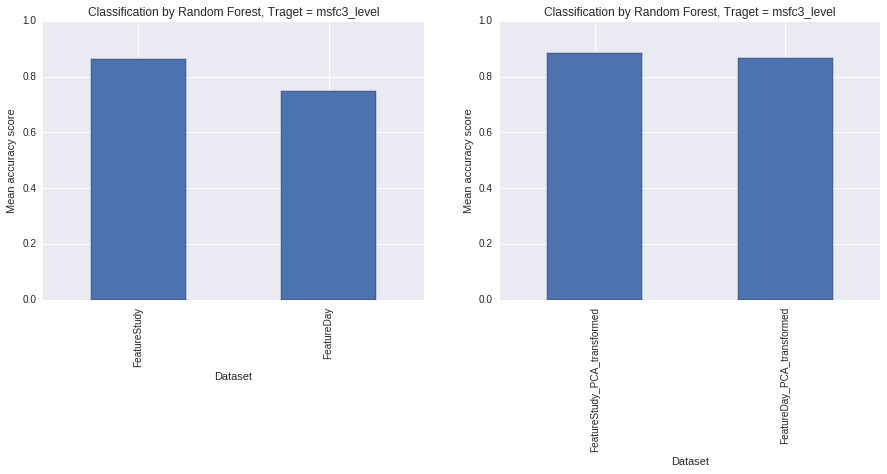

In [335]:
# visualize the accuracy of prediction resulted in scenarios above
figs, axes = plt.subplots(nrows= 1, ncols= 2)

axes[0] = summary_1.set_index('train_data')['mean_accuracy_score'].iloc[[0,1]].plot(kind='bar',ax=axes[0],figsize=(15,5))
axes[0].set_title('Classification by Random Forest, Traget = msfc3_level')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Mean accuracy score')
axes[0].set_ylim((0,1))

axes[0] = summary_2.set_index('train_data')['mean_accuracy_score'].iloc[[0,1]].plot(kind='bar',ax=axes[1])
axes[0].set_title('Classification by Random Forest, Traget = msfc3_level')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Mean accuracy score')
axes[0].set_ylim((0,1))

In [336]:
# repeat the process but this time exclude msfc scores as input features

In [337]:
# prepare x,y
# df_study
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin', 'msfc_composite_2', 'msfc_composite_1']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_study = df_study.drop(col_names_potential_targets,axis=1)
y_study = df_study['msfc_composite_3_bin']

# normalize data
from sklearn import preprocessing
x_study_scaled = pd.DataFrame(preprocessing.normalize(x_study),columns=x_study.columns)

In [338]:
# prepare x,y
# df_day
col_names_potential_targets = ['msfc_composite_3','msfc_change', 'msfc_composite_3_bin', 'msfc_composite_2', 'msfc_composite_1']
remove_cols = col_names_potential_targets.append('gls_subject_code')
x_day = df_day.drop(col_names_potential_targets,axis=1)
y_day = df_day['msfc_composite_3_bin']

# normalize data
from sklearn import preprocessing
x_day_scaled = pd.DataFrame(preprocessing.normalize(x_day),columns=x_day.columns)

In [339]:
# summerize the results in a dataframe
summary_1 = pd.DataFrame()
best_accuracy_score = []
accuracy_of_best_model_on_whole_data = []
best_num_of_estimator = []
train_data = []
target = []
num_of_samples = []
num_of_features = []

In [340]:
# random forest
# train data: df_study
# target: binned_msfc3
# validation: 10-fold cross validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
# train and fit the model
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': np.arange(5,100,5)}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=10)
grid_clf.fit(x_study, y_study)
# get the parameters
grid_clf.best_score_
grid_clf.best_params_
grid_clf.grid_scores_
# get the confusion matrix and accuracy_score
rf = grid_clf.best_estimator_
preds = rf.predict(x_study)
confusion_matrix(preds, y_study)
accuracy_score(preds, y_study)
# get the 20 first important features
l = rf.feature_importances_
df = pd.DataFrame()
df['feature'] = list(x_study.columns)
df['importance'] = l
df.sort('importance', ascending = False).head(20)
# store the result
best_accuracy_score.append(grid_clf.best_score_)
best_num_of_estimator.append(grid_clf.best_params_['n_estimators'])
train_data.append('FeatureStudy')
target.append('msfc3_level')
num_of_samples.append(len(y_study))
num_of_features.append(x_study.shape[1])
accuracy_of_best_model_on_whole_data.append(accuracy_score(preds, y_study))

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

0.81818181818181823

{'n_estimators': 10}

[mean: 0.59091, std: 0.36219, params: {'n_estimators': 5},
 mean: 0.81818, std: 0.17500, params: {'n_estimators': 10},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 15},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 20},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 25},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 30},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 35},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 40},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 45},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 50},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 55},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 60},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 65},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 70},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 75},
 mean: 0.77273, std: 0.18276, params: {'n_estimators': 80},
 mean: 0.77273, std: 0.18276, params: {'n

array([[ 2,  0,  0],
       [ 0,  4,  0],
       [ 0,  0, 16]])

1.0

/opt/python3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
23,mean_pvt_delay_7_at_home,0.244240
20,mean_pvt_delay_1_at_home,0.142282
52,mobility_activity_at_home_time,0.100000
21,mean_pvt_delay_3_at_home,0.068571
45,turn_vel_max_ankle_at_home,0.061404
39,turn_duration_at_home,0.057935
26,pq_nondominant_median_at_home,0.052991
37,mobility_swing_at_home,0.043147
10,turn_angle,0.042354
49,sway_dist_ap_at_home,0.031778


In [341]:
# random forest
# train data: df_day
# target: binned_msfc3
# validation: 10-fold cross validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
# train and fit the model
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': np.arange(5,100,5)}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=10)
grid_clf.fit(x_day, y_day)
# get the parameters
grid_clf.best_score_
grid_clf.best_params_
grid_clf.grid_scores_
# get the confusion matrix and accuracy_score
rf = grid_clf.best_estimator_
preds = rf.predict(x_day)
confusion_matrix(preds, y_day)
accuracy_score(preds, y_day)
# get the 20 first important features
l = rf.feature_importances_
df = pd.DataFrame()
df['feature'] = list(x_day.columns)
df['importance'] = l
df.sort('importance', ascending = False).head(20)
# store the result
best_accuracy_score.append(grid_clf.best_score_)
best_num_of_estimator.append(grid_clf.best_params_['n_estimators'])
train_data.append('FeatureDay')
target.append('msfc3_level')
num_of_samples.append(len(y_day))
num_of_features.append(x_day.shape[1])
accuracy_of_best_model_on_whole_data.append(accuracy_score(preds, y_day))

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

0.75

{'n_estimators': 5}

[mean: 0.75000, std: 0.20817, params: {'n_estimators': 5},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 10},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 15},
 mean: 0.70000, std: 0.22913, params: {'n_estimators': 20},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 25},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 30},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 35},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 40},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 45},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 50},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 55},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 60},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 65},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 70},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 75},
 mean: 0.75000, std: 0.20817, params: {'n_estimators': 80},
 mean: 0.75000, std: 0.20817, params: {'n

array([[ 2,  0,  0],
       [ 0,  2,  0],
       [ 0,  1, 15]])

0.94999999999999996

/opt/python3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
139,turn_vel_std_ankle_day_16,0.200000
964,turn_vel_max_ankle_day_37,0.168418
1044,turn_vel_max_ankle_day_53,0.128571
562,prv_sdnn_day_52,0.118539
386,turn_duration_day_19,0.109465
288,turn_duration_ankle_day_40,0.071429
933,turn_duration_day_50,0.058989
1323,hourly_temp_std_at_home_day_22,0.057613
1662,hourly_amb_temp_std_at_home_day_50,0.054054
511,walk_minutes_day_24,0.032922


In [342]:
# fill summary dataframe
summary_1['train_data'] = train_data
summary_1['target'] = target
summary_1['num_of_samples'] = num_of_samples
summary_1['num_of_features'] = num_of_features
summary_1['best_num_of_estimator'] = best_num_of_estimator
summary_1['mean_accuracy_score'] = best_accuracy_score
summary_1['accuracy_on_whole_data'] = accuracy_of_best_model_on_whole_data
summary_1

,train_data,target,num_of_samples,num_of_features,best_num_of_estimator,mean_accuracy_score,accuracy_on_whole_data
0,FeatureStudy,msfc3_level,22,60,10,0.818182,1.00
1,FeatureDay,msfc3_level,20,1826,5,0.750000,0.95


In [343]:
# PCA transformation

In [299]:
# normalize the data
# normalizing each feaure values in FeaturesDay based on the columns
x_study_normalized = (x_study - x_study.mean()) / (x_study.max() - x_study.min())
x_day_normalized = (x_day - x_day.mean()) / (x_day.max() - x_day.min())

In [300]:
# summerize the results in a dataframe
summary_2 = pd.DataFrame()
best_accuracy_score = []
num_of_estimators = []
train_data = []
target = []
num_of_samples = []
best_num_of_PCAs = []
accuracy_of_best_model_on_whole_data = []

In [301]:
# random forest
# train data: df_study, pca transformation
# target: binned_msfc3
# validation: 10-fold cross validation
# see how the number of PCs can change the accuracy of transformation

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
accuracy = []
n_estimators = 10
k = 10
# use various number of PCs
for pc_num in np.arange(1,20,1):
    # PCA transformation
    pca = PCA(n_components=pc_num)
    pca.fit(x_study_normalized)
    x_study_pca = pca.transform(x_study_normalized)
    # put the transformed data to a dataframe
    df_study_pca = pd.DataFrame(x_study_pca)
    # fit the model and do cross validation using PCA transformed dataset
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state = 42) #fix the number of estimators the best 
    accuracy.append(np.mean(cross_val_score(clf, df_study_pca, y_study, cv=k))) 
# max accuracy? what number of PCAs?
max_acc = accuracy[np.argmax(accuracy)]
best_num_of_PCA = np.arange(1,20,1)[np.argmax(accuracy)]
# print out the results
print(max_acc)
print(best_num_of_PCA)
# store the result
best_accuracy_score.append(max_acc)
best_num_of_PCAs.append(best_num_of_PCA)
train_data.append('FeatureStudy_PCA')
target.append('msfc3_level')
num_of_samples.append(len(y_study))
num_of_estimators.append(10)

PCA(copy=True, n_components=1, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=2, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=3, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=4, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=5, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=6, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=7, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=8, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=9, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=10, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=11, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=12, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=13, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=14, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=15, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=16, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=17, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=18, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=19, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


0.883333333333
2


In [302]:
# random forest
# train data: df_study, pca transformation
# target: binned_msfc3
# validation: 10-fold cross validation
# what is the best model accuracy on the whole dataset?

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
pc_num = 2
estimator_num = 10
k = 10
# PCA transformation
pca = PCA(n_components=pc_num)
pca.fit(x_study_normalized)
x_study_pca = pca.transform(x_study_normalized)
# variance explained by each PCA
explained_var = list(pca.explained_variance_)
PCA_list = np.arange(1, pc_num + 1)
df_explained_var = pd.DataFrame(explained_var,index=PCA_list,columns=['Explained Variance'])
df_explained_var
# put the transformed data to a dataframe
df_study_pca = pd.DataFrame(x_study_pca)
# fit the model and do cross validation using PCA transformed dataset
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': [estimator_num]}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=k)
grid_clf.fit(df_study_pca, y_study)
# try the model on the whole dataset
preds = grid_clf.best_estimator_.predict(df_study_pca)
accuracy_score(y_study, preds)
confusion_matrix(y_study, preds)
# store the result
accuracy_of_best_model_on_whole_data.append(accuracy_score(y_study, preds))

PCA(copy=True, n_components=2, whiten=False)

,Explained Variance
1,0.726197
2,0.464367


/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

1.0

array([[ 2,  0,  0],
       [ 0,  4,  0],
       [ 0,  0, 16]])

In [303]:
# random forest
# train data: df_day, pca transformation
# target: msfc3 level
# validation: 10-fold cross validation
# see how the number of PCs can change the accuracy of transformation

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
accuracy = []
n_estimators = 5
k = 10
# use various number of PCs
for pc_num in np.arange(1,20,1):
    # PCA transformation
    pca = PCA(n_components=pc_num)
    pca.fit(x_day_normalized)
    x_day_pca = pca.transform(x_day_normalized)
    # put the transformed data to a dataframe
    df_day_pca = pd.DataFrame(x_day_pca)
    # fit the model and do cross validation using PCA transformed dataset
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state = 42) #fix the number of estimators the best 
    accuracy.append(np.mean(cross_val_score(clf, df_day_pca, y_day, cv=k))) 
# max accuracy? what number of PCAs?
max_acc = accuracy[np.argmax(accuracy)]
best_num_of_PCA = np.arange(1,20,1)[np.argmax(accuracy)]
# print out the results
print(max_acc)
print(best_num_of_PCA)
# store the result
best_accuracy_score.append(max_acc)
best_num_of_PCAs.append(best_num_of_PCA)
train_data.append('FeatureDay_PCA')
target.append('msfc3_level')
num_of_samples.append(len(y_day))
num_of_estimators.append(5)

PCA(copy=True, n_components=1, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=2, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=3, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=4, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=5, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=6, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=7, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=8, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=9, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=10, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=11, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=12, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=13, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=14, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=15, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=16, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=17, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=18, whiten=False)

/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


PCA(copy=True, n_components=19, whiten=False)

0.866666666667
17


/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


In [304]:
# random forest
# train data: df_day, pca transformation
# target: binned_msfc3
# validation: 10-fold cross validation
# what is the best model accuracy on the whole dataset?

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
pc_num = 17
estimator_num = 5
k = 10
# PCA transformation
pca = PCA(n_components=pc_num)
pca.fit(x_day_normalized)
x_day_pca = pca.transform(x_day_normalized)
# variance explained by each PCA
explained_var = list(pca.explained_variance_)
PCA_list = np.arange(1, pc_num + 1)
df_explained_var = pd.DataFrame(explained_var,index=PCA_list,columns=['Explained Variance'])
df_explained_var
# put the transformed data to a dataframe
df_day_pca = pd.DataFrame(x_day_pca)
# fit the model and do cross validation using PCA transformed dataset
clf = RandomForestClassifier(random_state = 42) 
param_grid = {'n_estimators': [estimator_num]}
grid_clf = GridSearchCV(clf, param_grid = param_grid, cv=k)
grid_clf.fit(df_day_pca, y_day)
# try the model on the whole dataset
preds = grid_clf.best_estimator_.predict(df_day_pca)
accuracy_score(y_day, preds)
confusion_matrix(y_day, preds)
# store the result
accuracy_of_best_model_on_whole_data.append(accuracy_score(y_day, preds))

PCA(copy=True, n_components=17, whiten=False)

,Explained Variance
1,26.402221
2,20.824260
3,13.247958
4,10.643009
5,8.216776
6,7.078940
7,6.163901
8,4.722757
9,3.681870
10,2.728797


/opt/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'n_estimators': [5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

0.94999999999999996

array([[ 1,  0,  1],
       [ 0,  3,  0],
       [ 0,  0, 15]])

In [305]:
# fill summary dataframe
summary_2['train_data'] = train_data
summary_2['target'] = target
summary_2['num_of_samples'] = num_of_samples
summary_2['best_num_of_PCs'] = best_num_of_PCAs
summary_2['num_of_estimators'] = num_of_estimators
summary_2['mean_accuracy_score'] = best_accuracy_score
summary_2['accuracy_on_whole_data'] = accuracy_of_best_model_on_whole_data
summary_2

,train_data,target,num_of_samples,best_num_of_PCs,num_of_estimators,mean_accuracy_score,accuracy_on_whole_data
0,FeatureStudy_PCA,msfc3_level,22,2,10,0.883333,1.00
1,FeatureDay_PCA,msfc3_level,20,17,5,0.866667,0.95


(0, 1)

(0, 1)

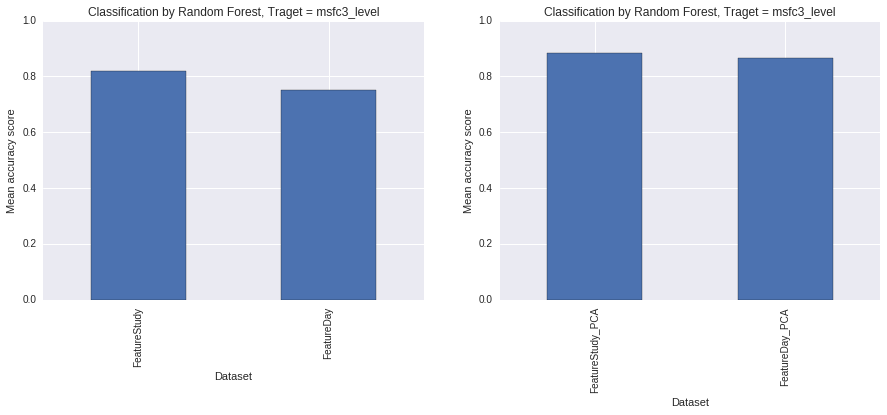

In [306]:
# visualize the resulted accuracies
figs, axes = plt.subplots(nrows= 1, ncols= 2)

axes[0] = summary_1.set_index('train_data')['mean_accuracy_score'].iloc[[0,1]].plot(kind='bar',ax=axes[0],figsize=(15,5))
axes[0].set_title('Classification by Random Forest, Traget = msfc3_level')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Mean accuracy score')
axes[0].set_ylim((0,1))

axes[0] = summary_2.set_index('train_data')['mean_accuracy_score'].iloc[[0,1]].plot(kind='bar',ax=axes[1])
axes[0].set_title('Classification by Random Forest, Traget = msfc3_level')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Mean accuracy score')
axes[0].set_ylim((0,1))